# Fly Flip Notebook
- First label images front and back
Then what we will do and then we can see if they face the front
- First orient all the images so they face the front...
- Second we will take the mean mask and ensure that it is oriented in the center so all masks need to be centered in the image
-

Will then use the average/mean mask as a template. With this template we should be able to compare to the original images and then determine the orientation.

Then will examine effectivness on test dataset..

Phases:
1. Import Depandencies
2. Set Data Source
3. Perform Image Labeling
    - Currently using OpenCV Method
    - Next Method: Using Tkinter GUI
4. Development of Average Mask
5. MSE Comparison
6. Plot of MSE

## Import Libraries

In [34]:
# Import Libraries
import sys
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2
import copy
import glob
import tkinter as tk
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
# plot_dir = os.path.join(current_dir,'plotting')
sys.path.append(current_dir)
# print(sys.path)
from lib.plotting import polarplot as polarplt# polar plotting module
from lib.parsing import basic_sections as bsc_sec # basic data parsing methods
from lib.parsing.data_range import find_startdata, find_enddata # setting start and end of analysis region 
from lib.parsing.exact_exp_groups import sub_exp_group  # more dataparsing methods
from lib.led_convert import get_LED_angle_in_rad
from lib.plotting.flyviz import get_contour_centroid, get_objectmask, get_fill_flymask, contour_hrz_matrix
from scipy import interpolate
from find_fly_angle.find_fly_anglev2 import *

c:\Users\lkrow\vscodeProjects\My-Repos-Warren-Lab\flyplot


## Set Data Source

Provide path to the image dataset that will be referenced throughout this notebook.

In [35]:
# Path to Image Dataset
# Linux and MacOS
# data = glob.glob('/Volumes/No Name/20240502125110/*.png')
data = glob.glob('D:/20240502125110/*.png')

Determine the number of images in the dataset

In [36]:
for f in range(len(data)):
# np.where(file.split('/')[-1].strip('.png') == 20240502125110_5669')
    if data[f].split('/')[-1].split('\\')[-1].strip('.png') == '20240502125110_1332':
        print(f)

1137


## (Optional) Test Image

To ensure that all dependancies are working appropriately, an image source internally within this package will be used to test the `contour_hrz_matrix` method.

Alternatively, you can utilize a different image.

In [37]:
file ="20240415120905_0121"
file_name = "imgs/" + file +".png"
fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz, angle_og, angle_rot = contour_hrz_matrix(file_name)

Angle Test!
Angle Value: -150.81302529857444
My Angle Value: 238.3739494028511
Angle Test!
Angle Value: 89.07785336571138
My Angle Value: 358.15570673142275


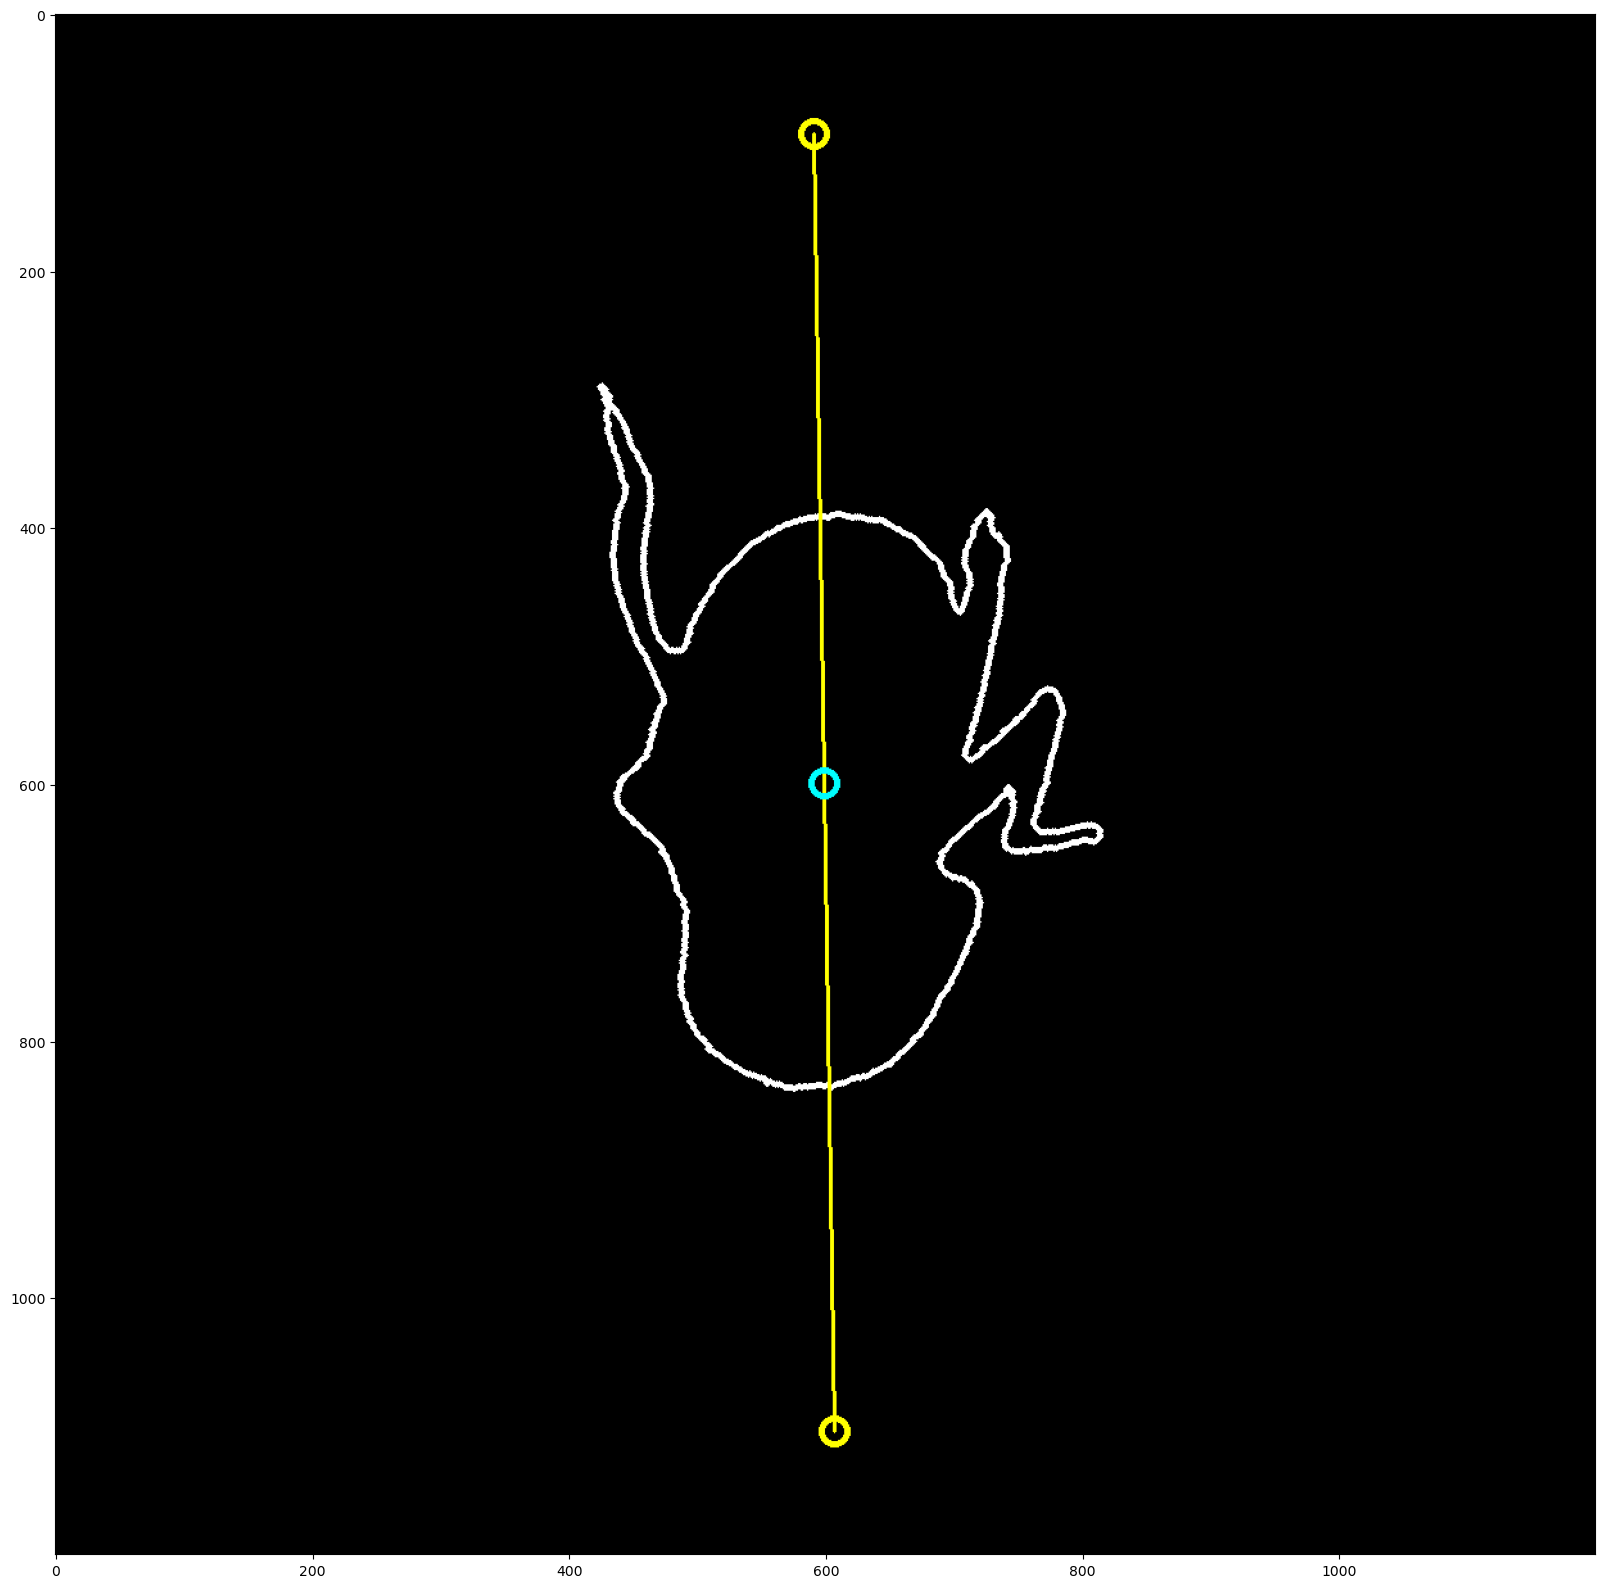

In [38]:
plt.figure(figsize=(20,20))
mask_fly = get_objectmask(fly_mask_hrz,max_contour_hrz)

cv2.circle(mask_fly,body_axis_pt_0_hrz,10, color = (255,255,0),thickness =3)
cv2.circle(mask_fly,body_axis_pt_1_hrz,10, color = (255,255,0),thickness =3)
cv2.line(mask_fly,body_axis_pt_0_hrz,body_axis_pt_1_hrz,color = (255,255,0), thickness = 2)
cv2.circle(mask_fly,centroid_hrz,10,color = (0,255,255),thickness=3)
plt.imshow(mask_fly)

## Labeling
After verifying that your dependancies are working, proceed to label 20 random images of flies from the path provided initially. The labeling process is to assign each image an indication of whether or not the Non Rotated or Rotated image best represents a Fly.

Three Images will be displayed, with the first image represeting the original fly orientation, the second the rotated and transformed fly based on it's orientation (which will allow it to be oriented along the central vertical axis). The last image is a subsequent 180 degree rotation of the fly after the initial rotation and transformation....

Essentially the labeling is a selection between the last two images. After making this selection that image will be saved in order to generate an average mask.

The Criteria for Labeling:
- Fly head facing up in an image then use the respective 'n' or 'r' to assign that image to the fly. with `n` corresponding to `No Rotation` and `r` corresponding to `Rotation`

In [39]:
imgs = {}
import time
import glob
import random
def img_label(filename):
    """
    For each image we will need to ensure that the proper rotation is performed such that it is in the 
    top down rotation
    
    """
    fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(filename)
# mask_fly_norot = get_objectmask(fly_mask_hrz,max_contour_hrz)
    mask_fly_rot = cv2.rotate(copy.deepcopy(fly_mask_hrz),cv2.ROTATE_180)
    dict_img ={
        "n": fly_mask_hrz,
        "r":mask_fly_rot
    }
#     for i in range(1):
    ## test various rotations (0 or 180)
    fig = plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(fly_mask_orig,cmap='gray')
    print(f"<< Original Angle: {np.rad2deg(angle_og)} >>")
    plt.subplot(1,3,2)
    plt.title("No Rotation")
    # print("No Rotation Angle:",np.rad2deg(angle))
    print(f"<< No Rotation Angle: {np.rad2deg(angle_og)} >>")
    plt.imshow(fly_mask_hrz,cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Rotation")
    print(f"<< Rotation Angle: {np.rad2deg(angle_og)-180} >>")
    plt.imshow(mask_fly_rot,cmap='gray')
    plt.show()
    
    fly_up = input("Input the name of No Rotation or Rotation depending on which one display fly pointed up. ")
    mask_fly = dict_img[fly_up]
    
    return mask_fly

['D:/20240502125110\\20240502125110_7498.png', 'D:/20240502125110\\20240502125110_8283.png', 'D:/20240502125110\\20240502125110_7622.png', 'D:/20240502125110\\20240502125110_6571.png', 'D:/20240502125110\\20240502125110_4865.png', 'D:/20240502125110\\20240502125110_7015.png', 'D:/20240502125110\\20240502125110_4380.png', 'D:/20240502125110\\20240502125110_3917.png', 'D:/20240502125110\\20240502125110_6932.png', 'D:/20240502125110\\20240502125110_8253.png', 'D:/20240502125110\\20240502125110_5131.png', 'D:/20240502125110\\20240502125110_3453.png', 'D:/20240502125110\\20240502125110_8600.png', 'D:/20240502125110\\20240502125110_8518.png', 'D:/20240502125110\\20240502125110_4387.png', 'D:/20240502125110\\20240502125110_6902.png', 'D:/20240502125110\\20240502125110_7929.png', 'D:/20240502125110\\20240502125110_0239.png', 'D:/20240502125110\\20240502125110_7225.png', 'D:/20240502125110\\20240502125110_7588.png', 'D:/20240502125110\\20240502125110_6900.png', 'D:/20240502125110\\2024050212511

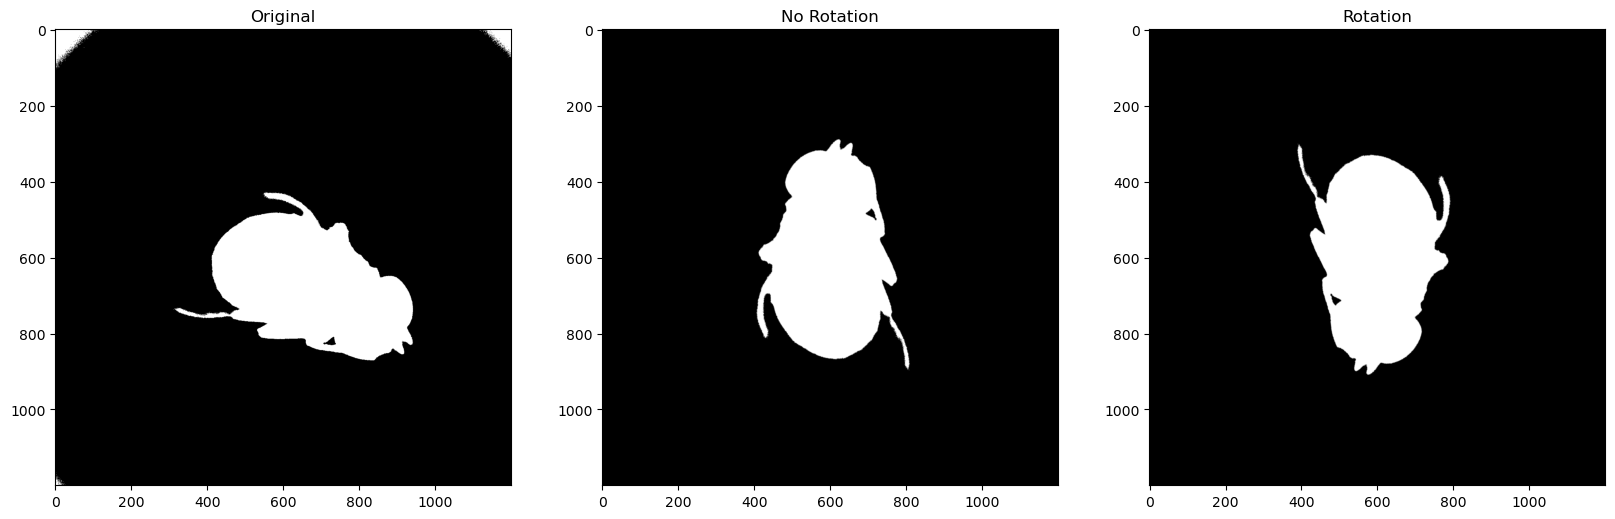

Angle Test!
Angle Value: 112.39742849649146
My Angle Value: 44.794856992982915
Angle Test!
Angle Value: 89.92303790103036
My Angle Value: 359.8460758020607
<< Original Angle: 112.39742849649144 >>
<< No Rotation Angle: 112.39742849649144 >>
<< Rotation Angle: -67.60257150350856 >>


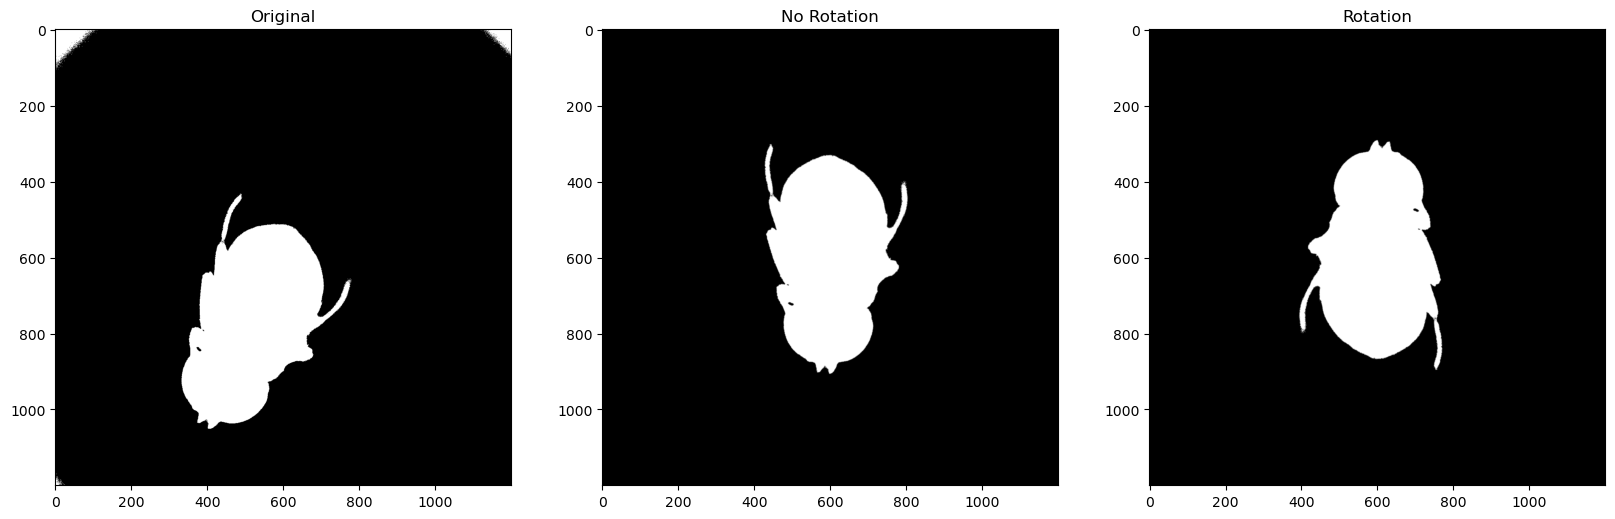

Angle Test!
Angle Value: -175.9840133819911
My Angle Value: 188.03197323601785
Angle Test!
Angle Value: 90.01640275287373
My Angle Value: 0.03280550574748986
<< Original Angle: -175.9840133819911 >>
<< No Rotation Angle: -175.9840133819911 >>
<< Rotation Angle: -355.9840133819911 >>


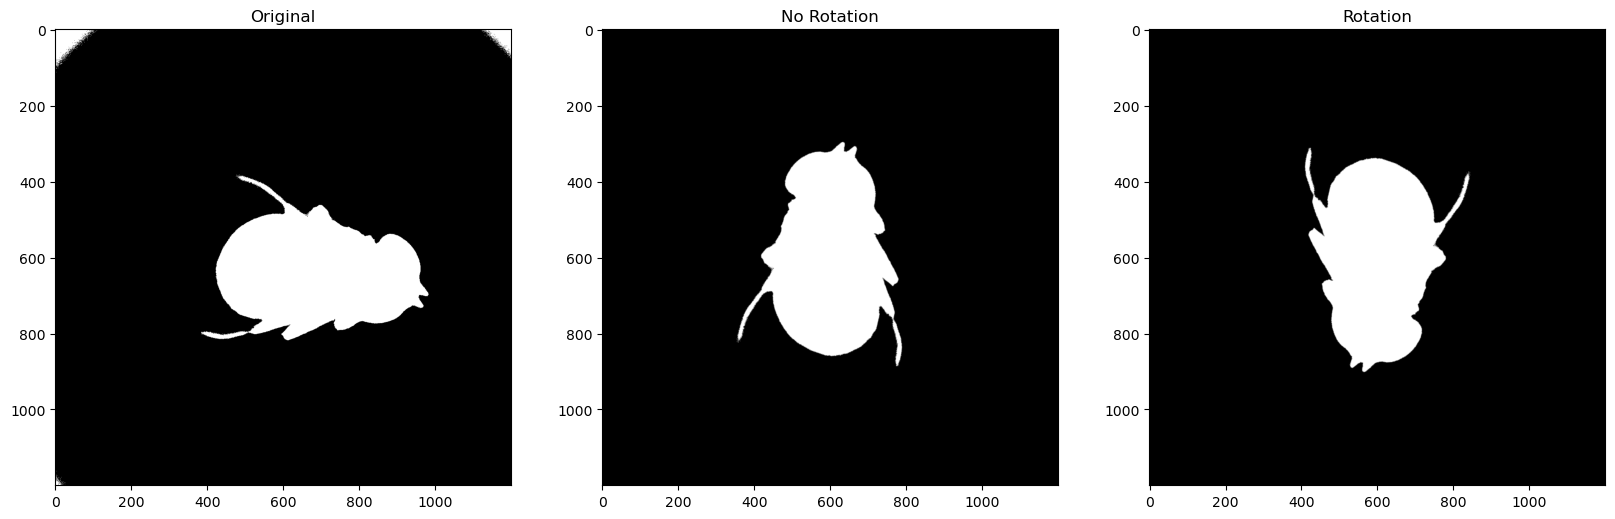

Angle Test!
Angle Value: 94.2165221911095
My Angle Value: 8.43304438221898
Angle Test!
Angle Value: 90.024601532048
My Angle Value: 0.04920306409599107
<< Original Angle: 94.21652219110949 >>
<< No Rotation Angle: 94.21652219110949 >>
<< Rotation Angle: -85.78347780889051 >>


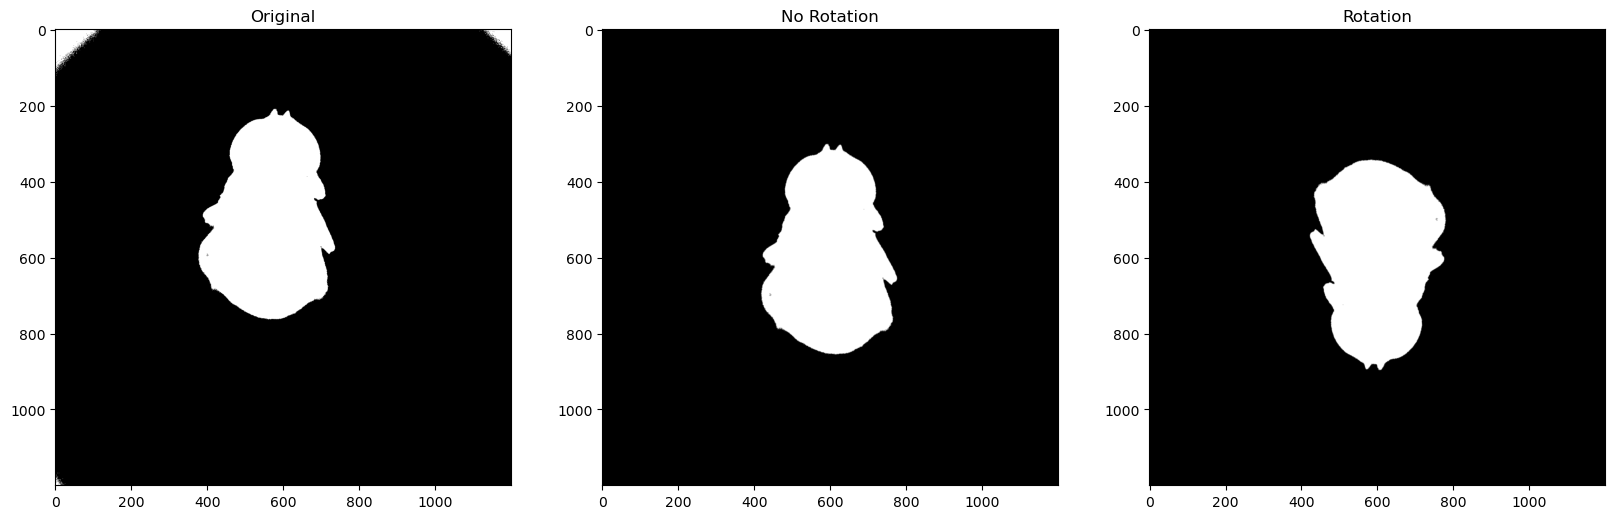

Angle Test!
Angle Value: 153.65782312920663
My Angle Value: 127.31564625841324
Angle Test!
Angle Value: 89.709353578651
My Angle Value: 359.41870715730204
<< Original Angle: 153.65782312920663 >>
<< No Rotation Angle: 153.65782312920663 >>
<< Rotation Angle: -26.342176870793367 >>


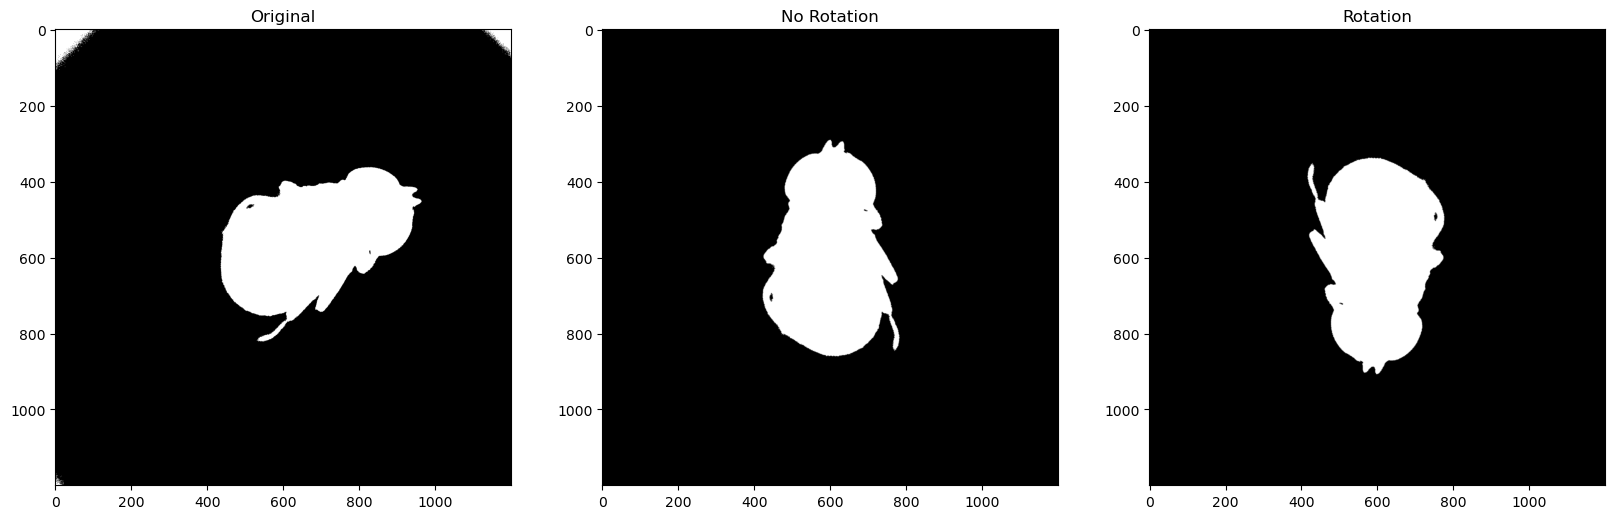

Angle Test!
Angle Value: 60.9677761703095
My Angle Value: 301.935552340619
Angle Test!
Angle Value: 90.03986106877548
My Angle Value: 0.07972213755095936
<< Original Angle: 60.96777617030948 >>
<< No Rotation Angle: 60.96777617030948 >>
<< Rotation Angle: -119.03222382969052 >>


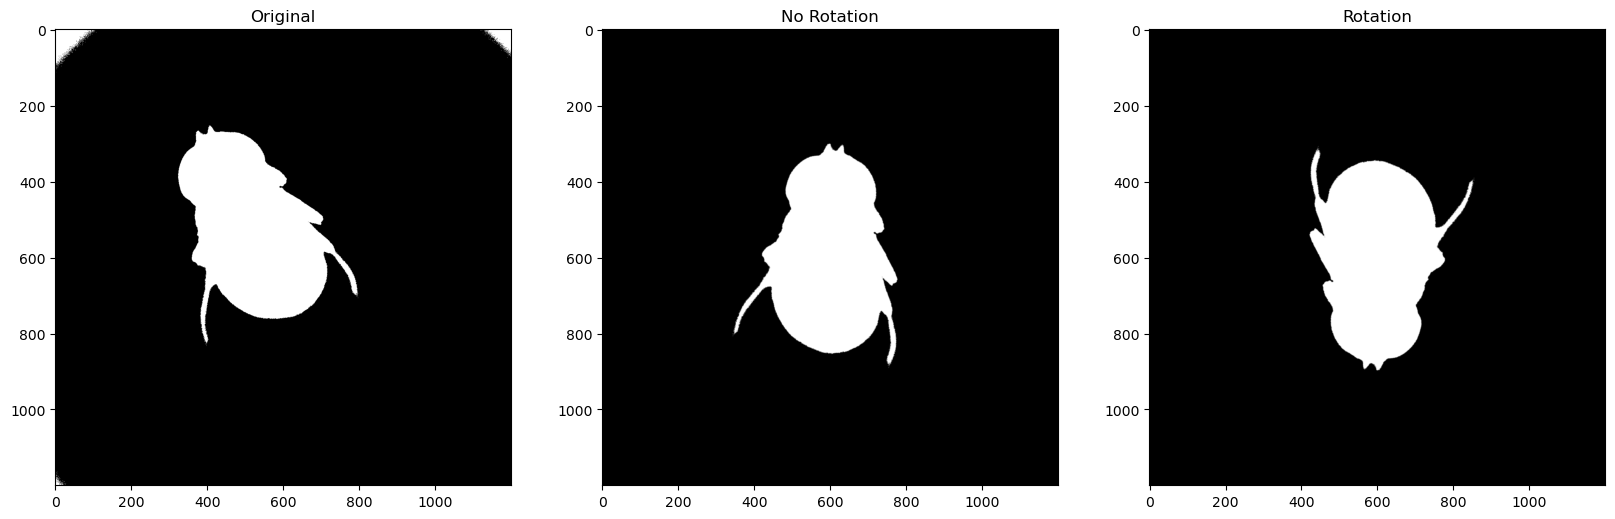

Angle Test!
Angle Value: 90.3228329124594
My Angle Value: 0.6456658249187797
Angle Test!
Angle Value: 89.9636189977629
My Angle Value: 359.9272379955258
<< Original Angle: 90.32283291245939 >>
<< No Rotation Angle: 90.32283291245939 >>
<< Rotation Angle: -89.67716708754061 >>


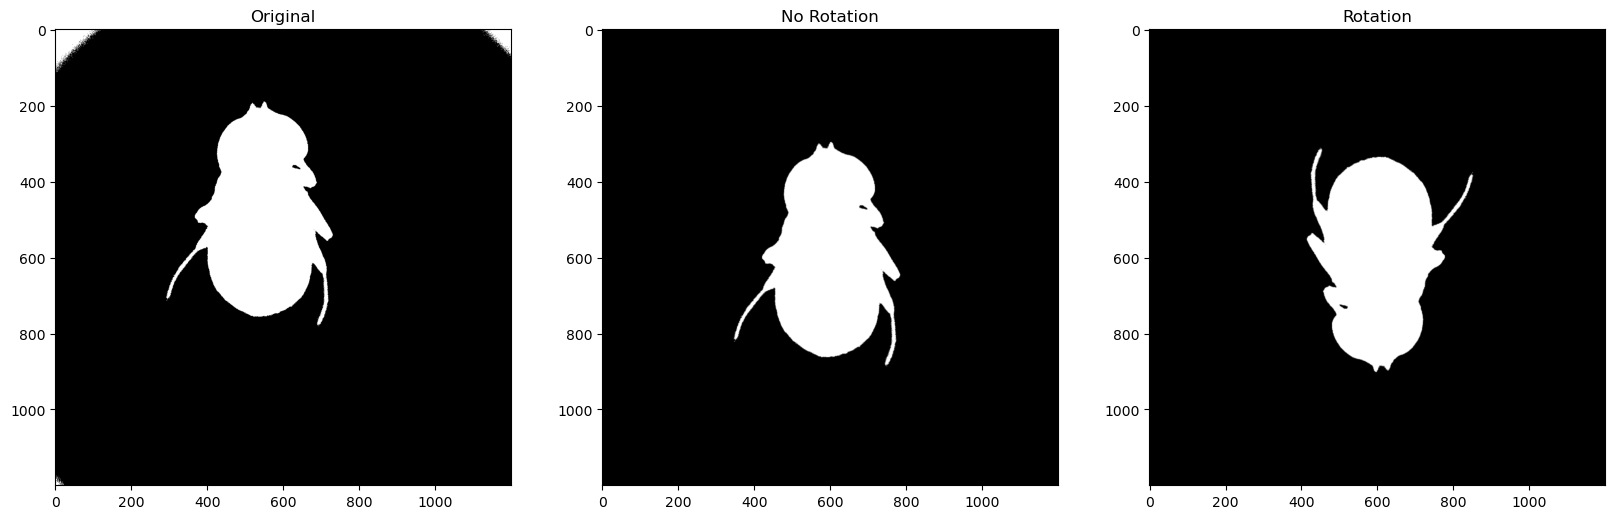

Angle Test!
Angle Value: 106.5600318249901
My Angle Value: 33.12006364998021
Angle Test!
Angle Value: 91.72060658604875
My Angle Value: 3.4412131720974912
<< Original Angle: 106.56003182499012 >>
<< No Rotation Angle: 106.56003182499012 >>
<< Rotation Angle: -73.43996817500988 >>


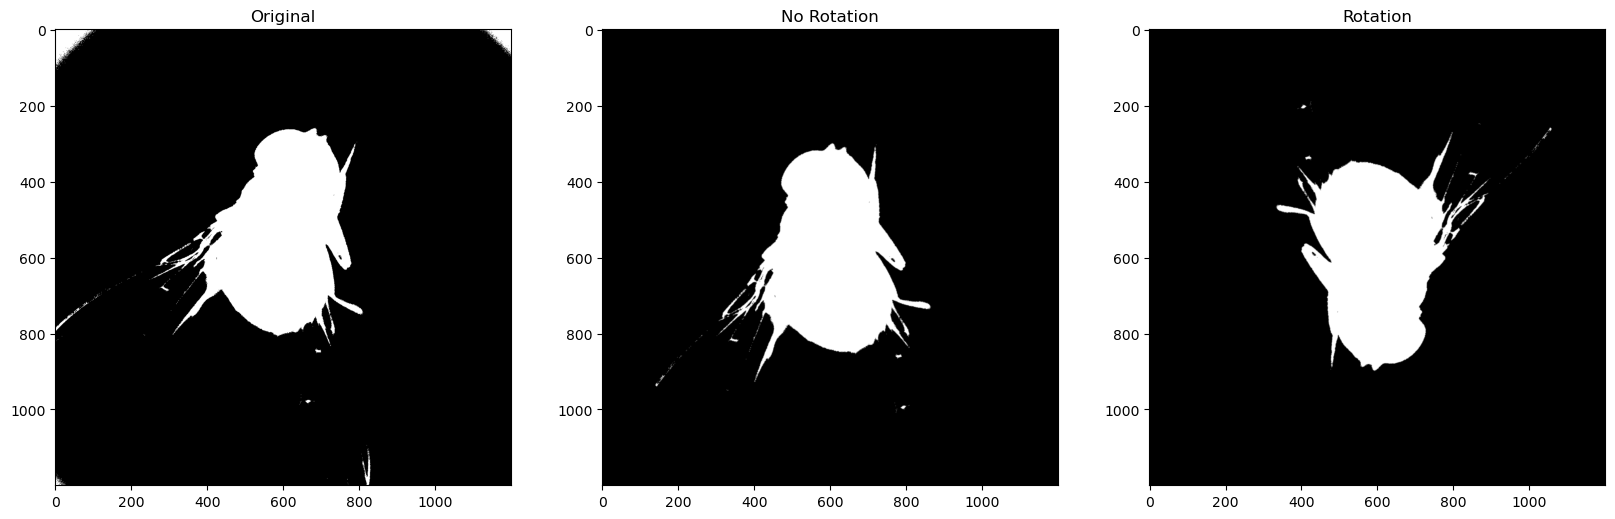

Angle Test!
Angle Value: 53.27239317515069
My Angle Value: 286.54478635030137
Angle Test!
Angle Value: 90.14019350323868
My Angle Value: 0.2803870064773264
<< Original Angle: 53.27239317515067 >>
<< No Rotation Angle: 53.27239317515067 >>
<< Rotation Angle: -126.72760682484933 >>


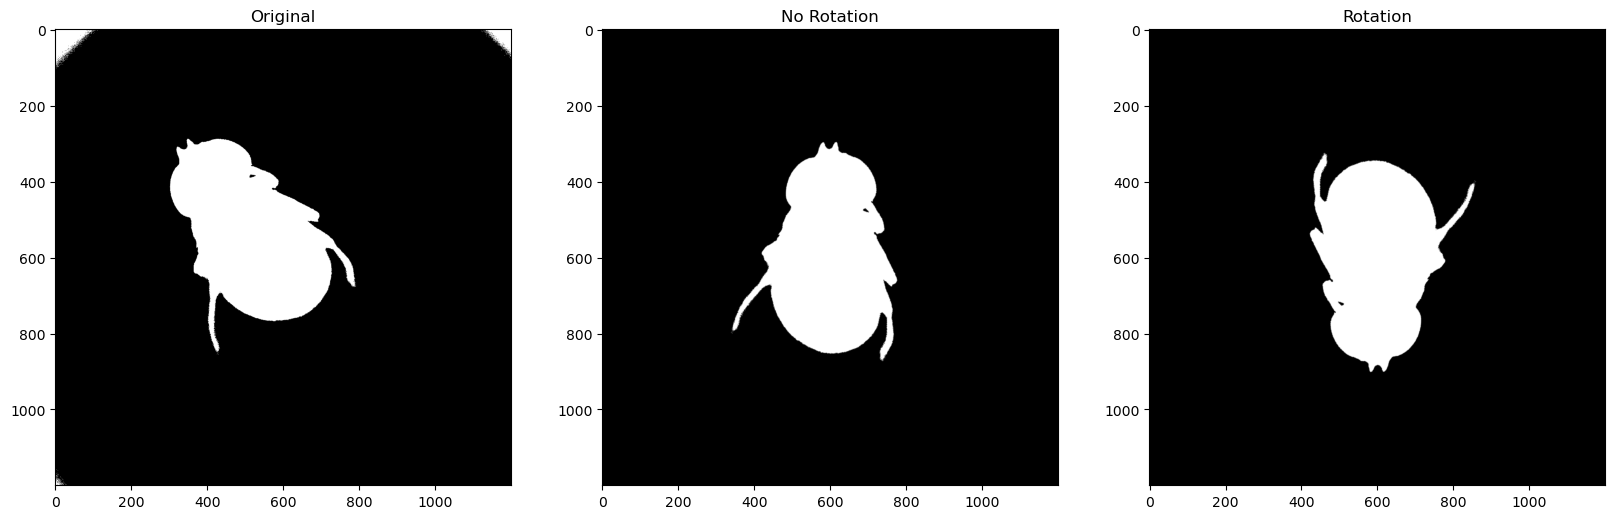

Angle Test!
Angle Value: 140.7504358206217
My Angle Value: 101.50087164124336
Angle Test!
Angle Value: 89.91304150693219
My Angle Value: 359.8260830138644
<< Original Angle: 140.7504358206217 >>
<< No Rotation Angle: 140.7504358206217 >>
<< Rotation Angle: -39.2495641793783 >>


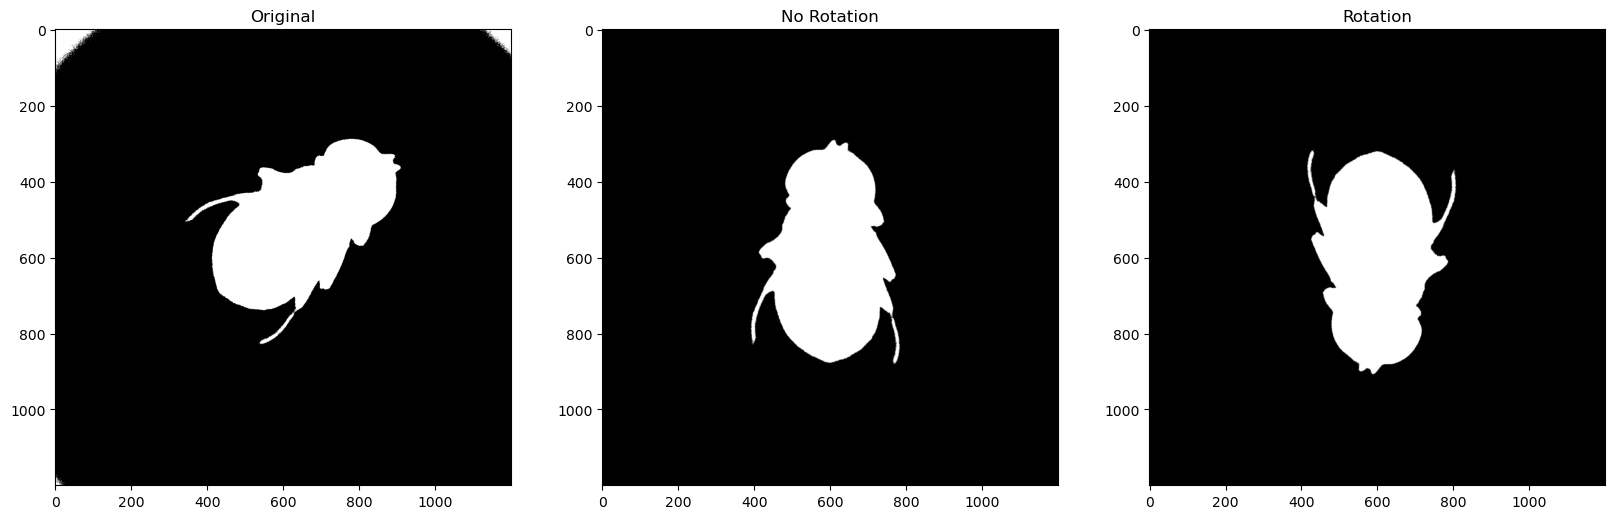

Angle Test!
Angle Value: 154.71700010216483
My Angle Value: 129.4340002043296
Angle Test!
Angle Value: 90.53092092404806
My Angle Value: 1.0618418480961225
<< Original Angle: 154.7170001021648 >>
<< No Rotation Angle: 154.7170001021648 >>
<< Rotation Angle: -25.282999897835197 >>


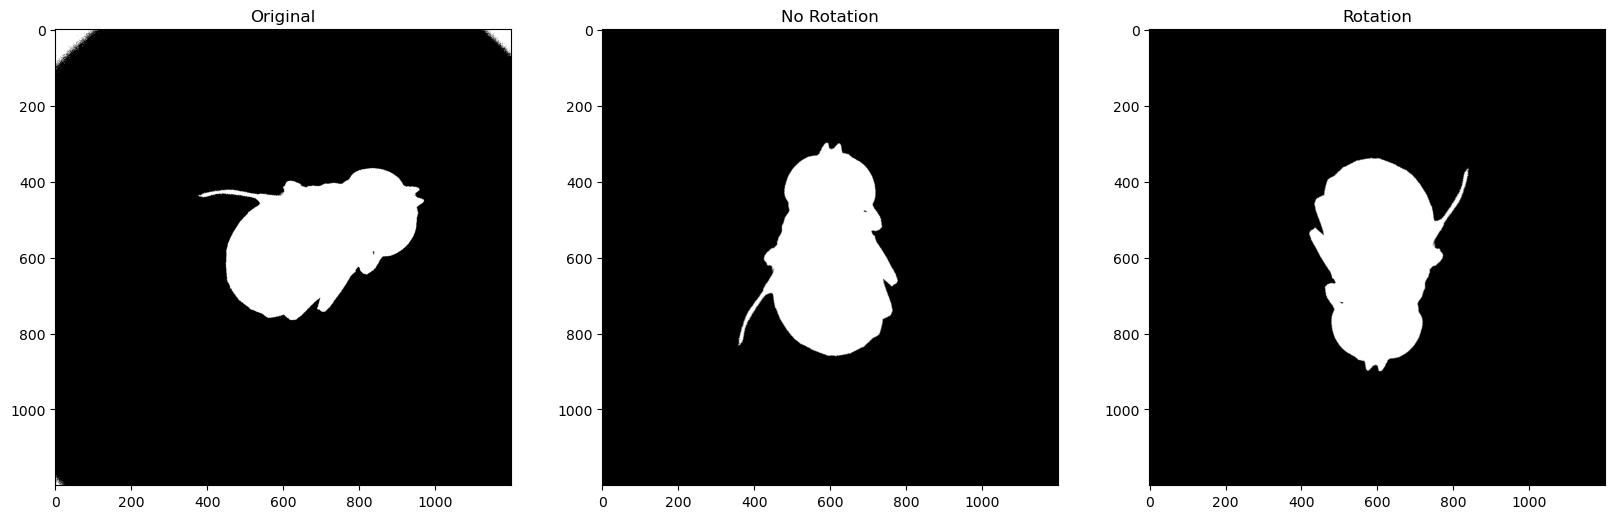

Angle Test!
Angle Value: 84.96181564247087
My Angle Value: 349.92363128494173
Angle Test!
Angle Value: 90.04209494849498
My Angle Value: 0.08418989698992618
<< Original Angle: 84.96181564247085 >>
<< No Rotation Angle: 84.96181564247085 >>
<< Rotation Angle: -95.03818435752915 >>


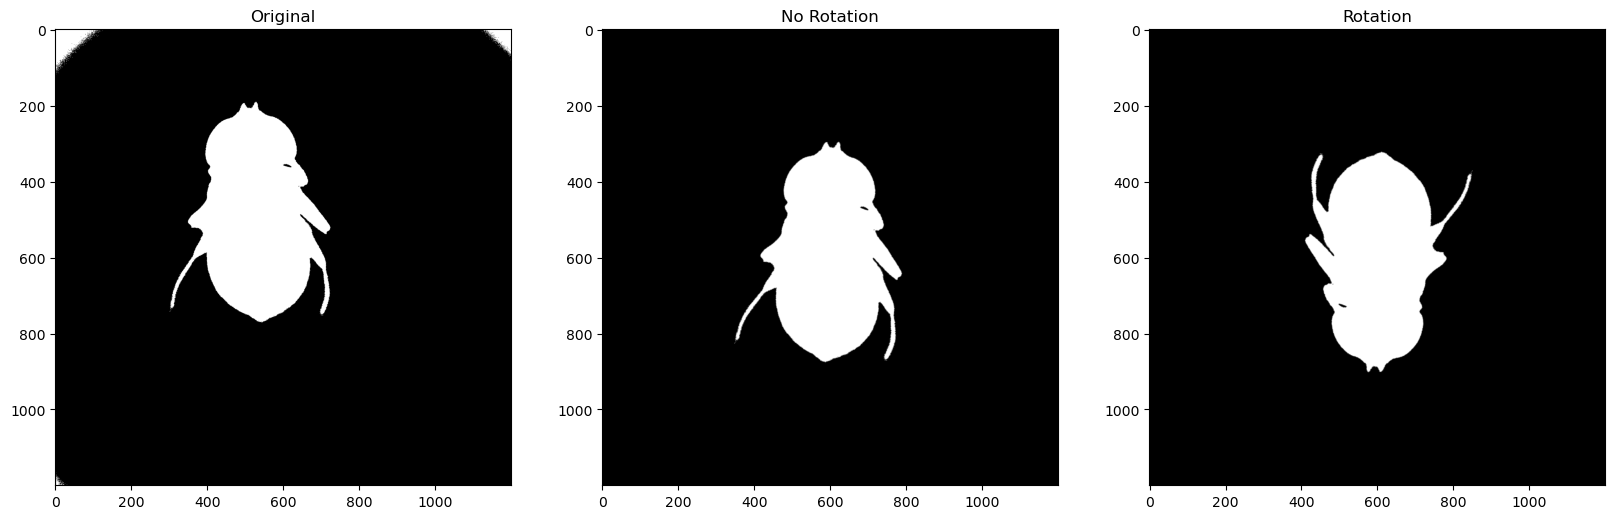

Angle Test!
Angle Value: 138.4345856671017
My Angle Value: 96.86917133420336
Angle Test!
Angle Value: 89.87815505500276
My Angle Value: 359.75631011000553
<< Original Angle: 138.4345856671017 >>
<< No Rotation Angle: 138.4345856671017 >>
<< Rotation Angle: -41.565414332898314 >>


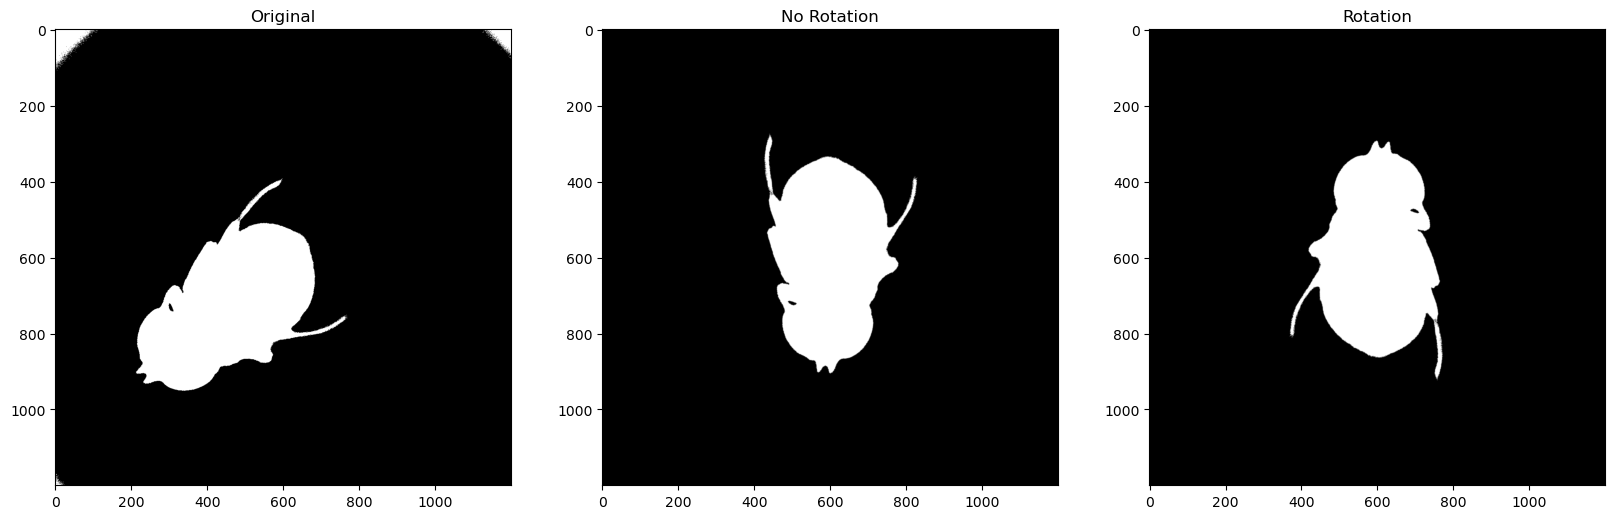

Angle Test!
Angle Value: 134.6530461127233
My Angle Value: 89.30609222544656
Angle Test!
Angle Value: 89.89572218530657
My Angle Value: 359.79144437061314
<< Original Angle: 134.6530461127233 >>
<< No Rotation Angle: 134.6530461127233 >>
<< Rotation Angle: -45.3469538872767 >>


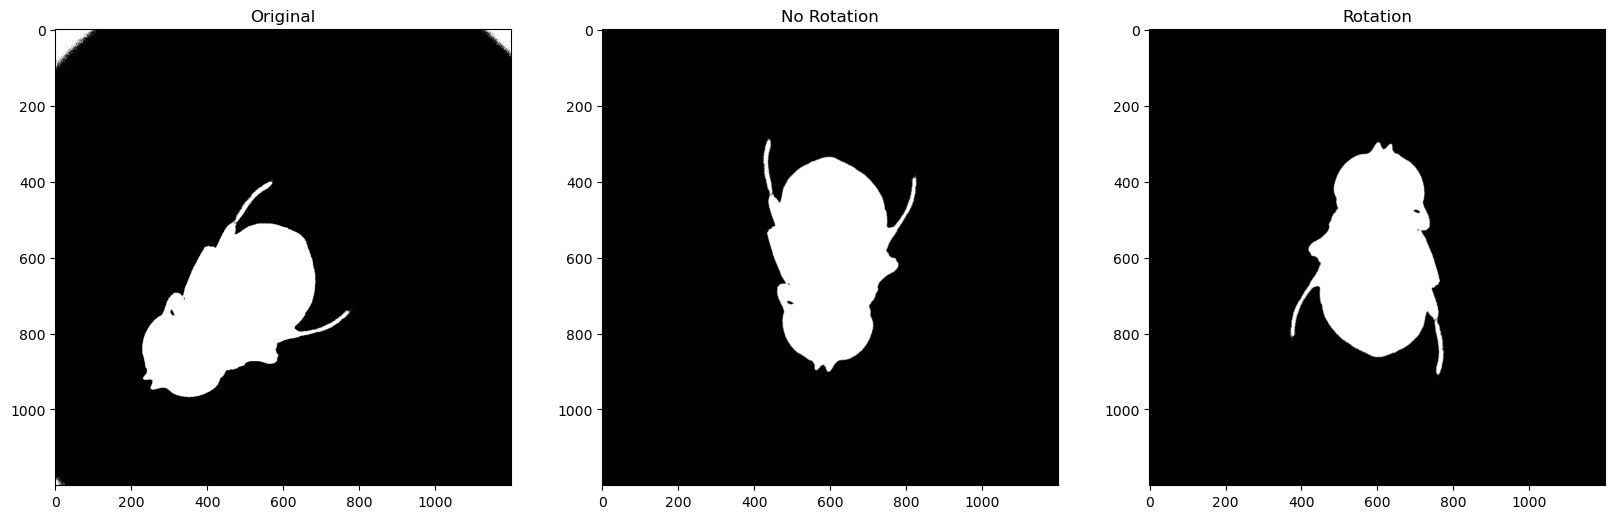

Angle Test!
Angle Value: 85.92555439963508
My Angle Value: 351.85110879927015
Angle Test!
Angle Value: 89.9940281942578
My Angle Value: 359.9880563885156
<< Original Angle: 85.92555439963509 >>
<< No Rotation Angle: 85.92555439963509 >>
<< Rotation Angle: -94.07444560036491 >>


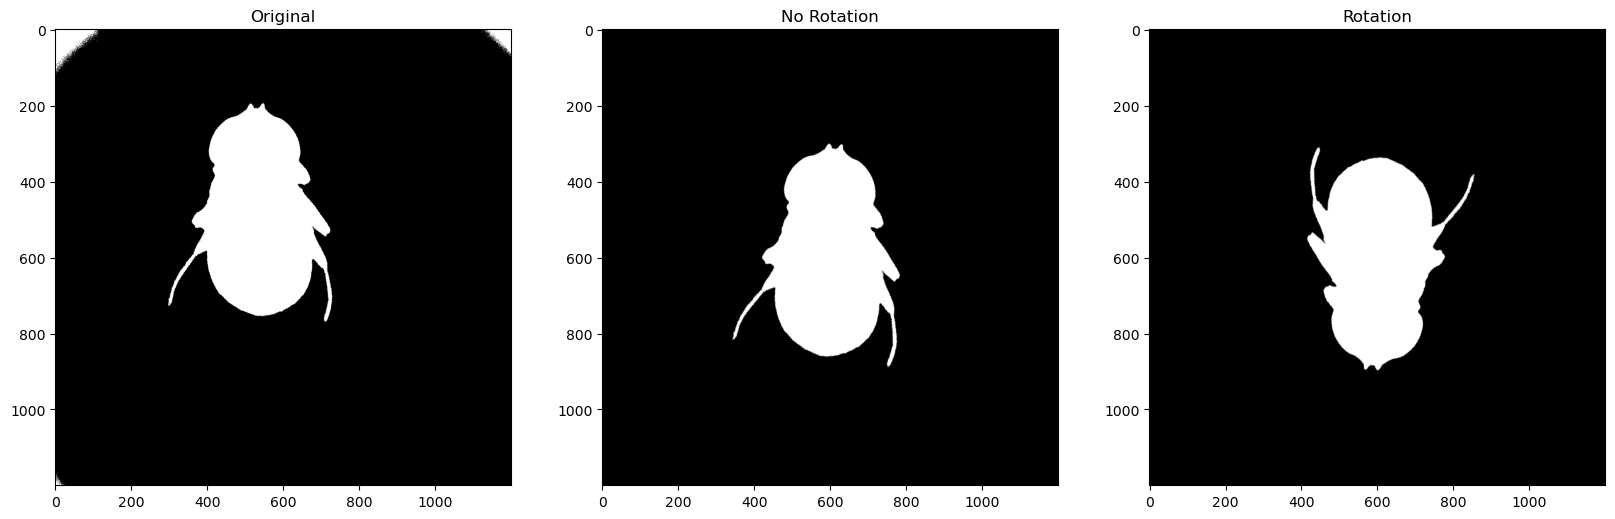

Angle Test!
Angle Value: 49.771520027785954
My Angle Value: 279.5430400555719
Angle Test!
Angle Value: 90.32591332857046
My Angle Value: 0.6518266571409015
<< Original Angle: 49.77152002778595 >>
<< No Rotation Angle: 49.77152002778595 >>
<< Rotation Angle: -130.22847997221405 >>


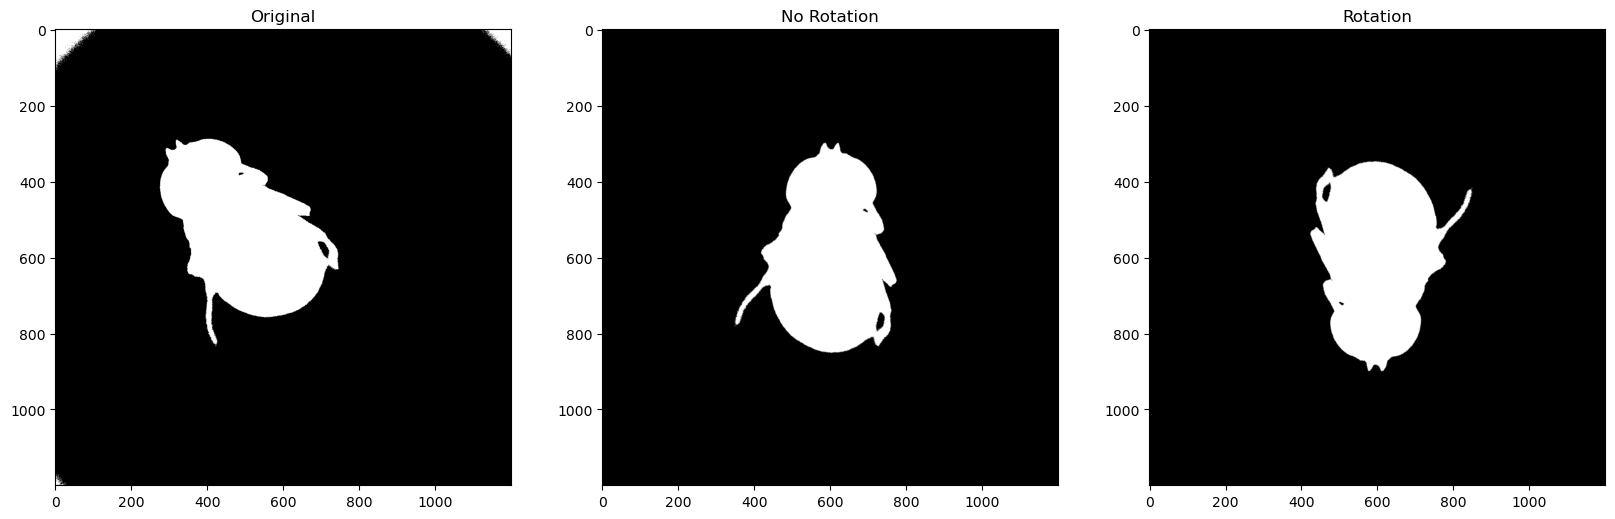

Angle Test!
Angle Value: -160.20939935889535
My Angle Value: 219.58120128220935
Angle Test!
Angle Value: 89.83820577899299
My Angle Value: 359.67641155798594
<< Original Angle: -160.20939935889535 >>
<< No Rotation Angle: -160.20939935889535 >>
<< Rotation Angle: -340.2093993588953 >>


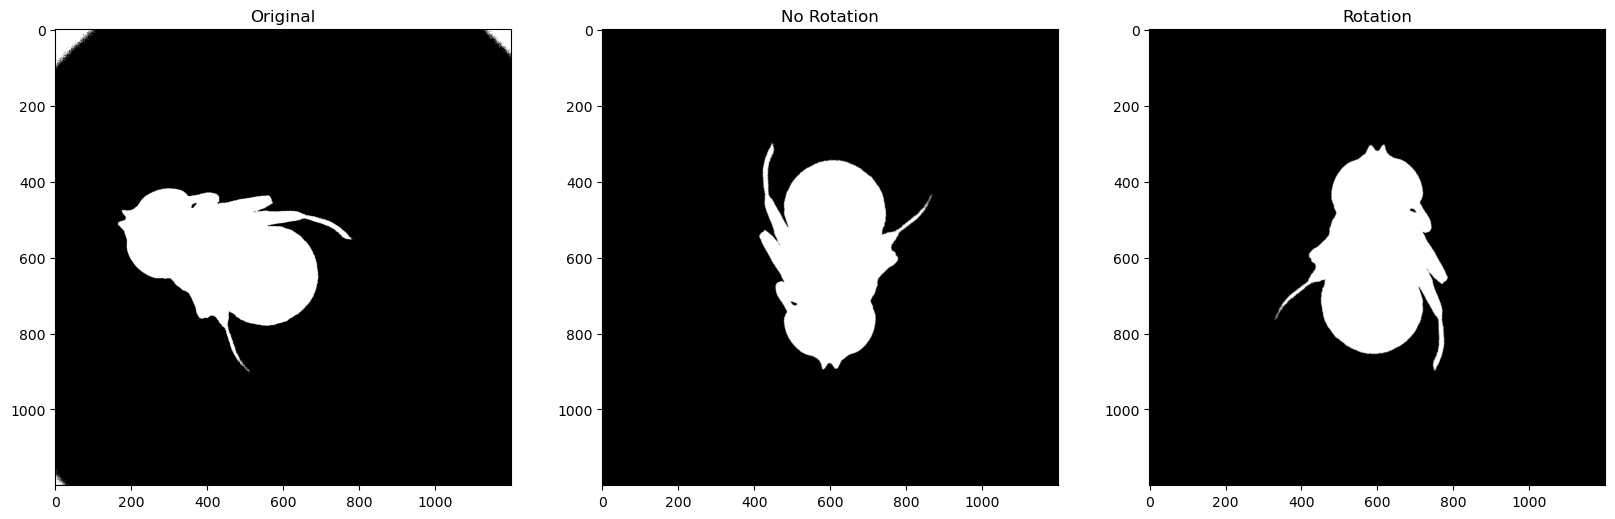

Angle Test!
Angle Value: -179.51403764371014
My Angle Value: 180.97192471257975
Angle Test!
Angle Value: 89.83351155562634
My Angle Value: 359.66702311125266
<< Original Angle: -179.51403764371014 >>
<< No Rotation Angle: -179.51403764371014 >>
<< Rotation Angle: -359.51403764371014 >>


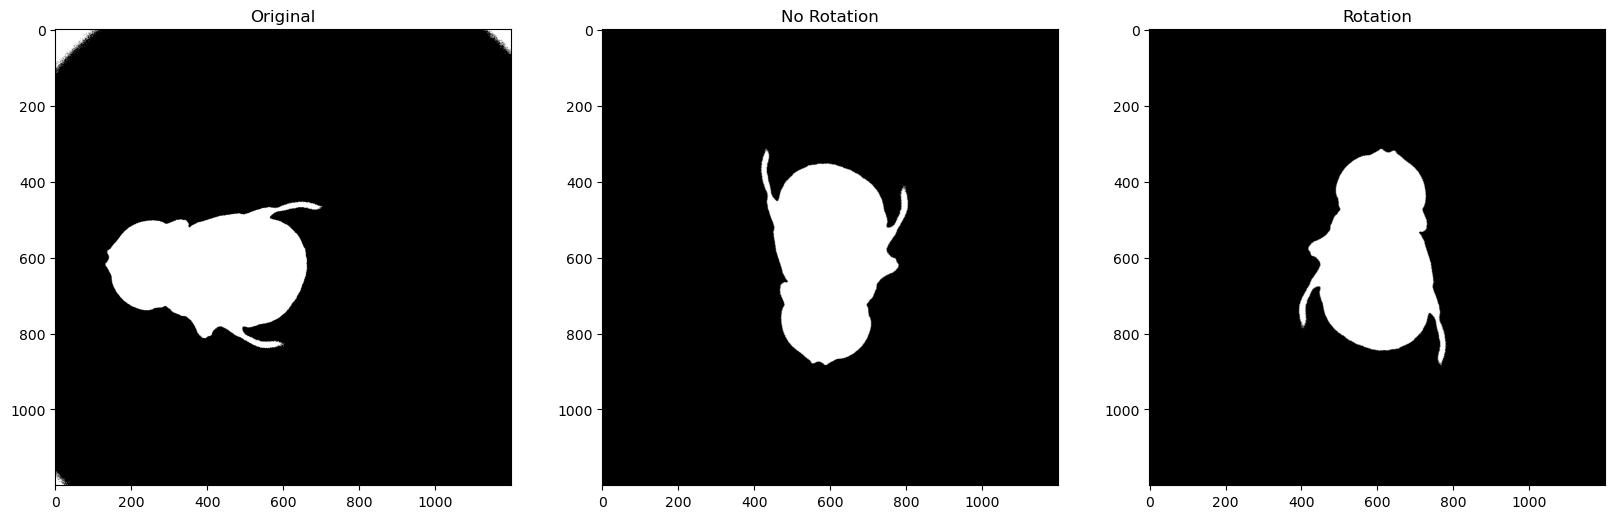

Angle Test!
Angle Value: 75.17239465994302
My Angle Value: 330.34478931988605
Angle Test!
Angle Value: 89.95320629394791
My Angle Value: 359.90641258789583
<< Original Angle: 75.17239465994302 >>
<< No Rotation Angle: 75.17239465994302 >>
<< Rotation Angle: -104.82760534005698 >>


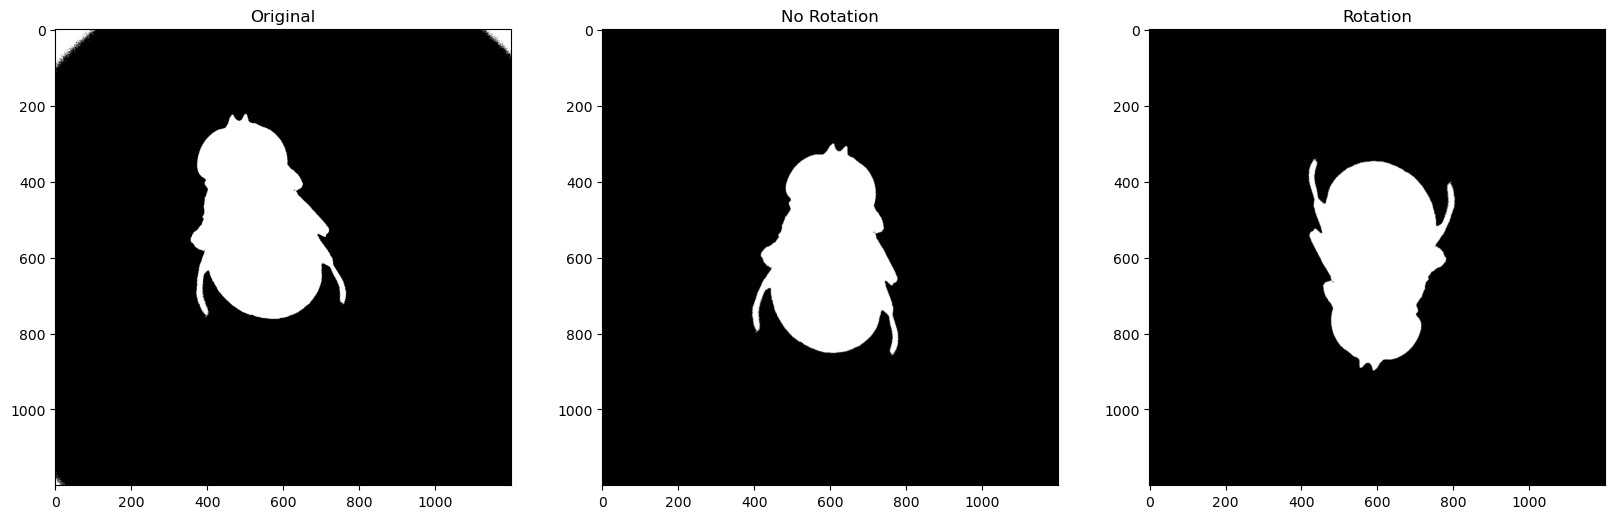

Angle Test!
Angle Value: 82.47689570291503
My Angle Value: 344.9537914058301
Angle Test!
Angle Value: 90.11430209565975
My Angle Value: 0.2286041913194765
<< Original Angle: 82.47689570291503 >>
<< No Rotation Angle: 82.47689570291503 >>
<< Rotation Angle: -97.52310429708497 >>


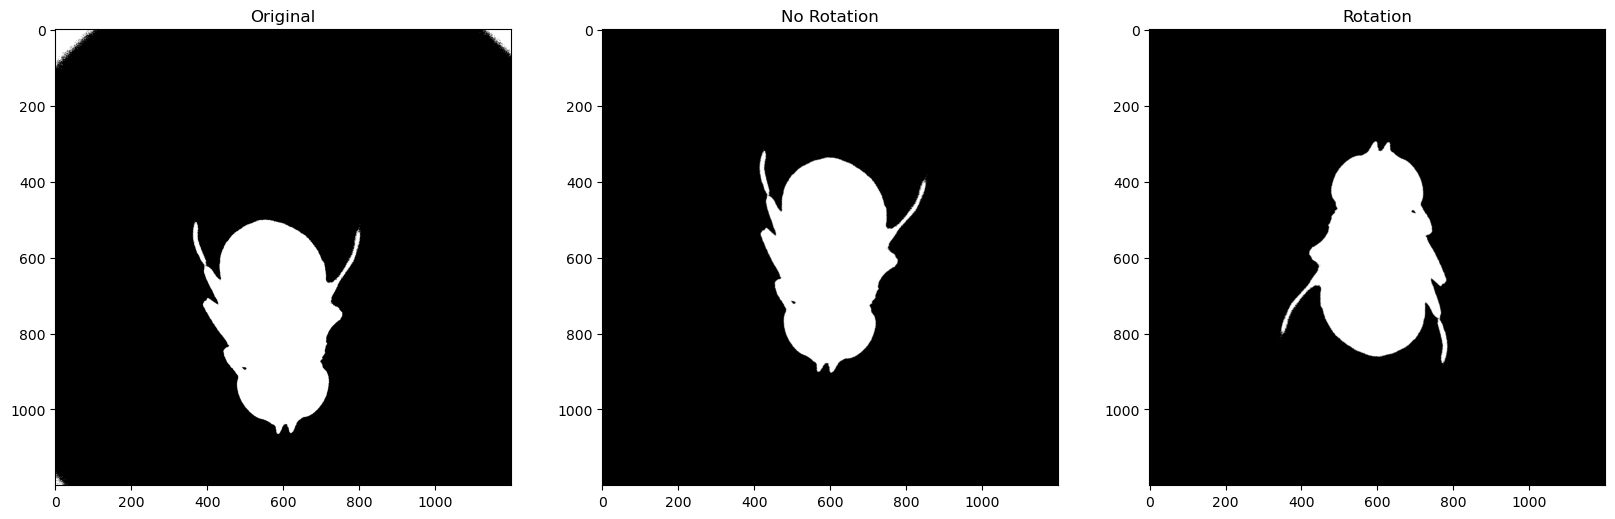

In [42]:
# get all of the files in the folder
# shuffled_list = sorted(glob.glob('/media/flyranch/T7 Shield/flyflipimgs/20240502125110/*.png'), key=lambda x: random.random())
shuffled_list = sorted(data, key=lambda x: random.random())
print(shuffled_list)
for file in shuffled_list[:20]:
    name = file.split('/')[-1].strip('.png')
    mask_fly = img_label(file)
    imgs[name] = mask_fly
    # execute function and then add these images and etc to the dictionary

## Average Fly Mask Template 
Using the 20 labelled images, a grayscale template mask will be developed of the fly facing upward. This average mask will then be tested against all images in the dataset to determine correct orientation.

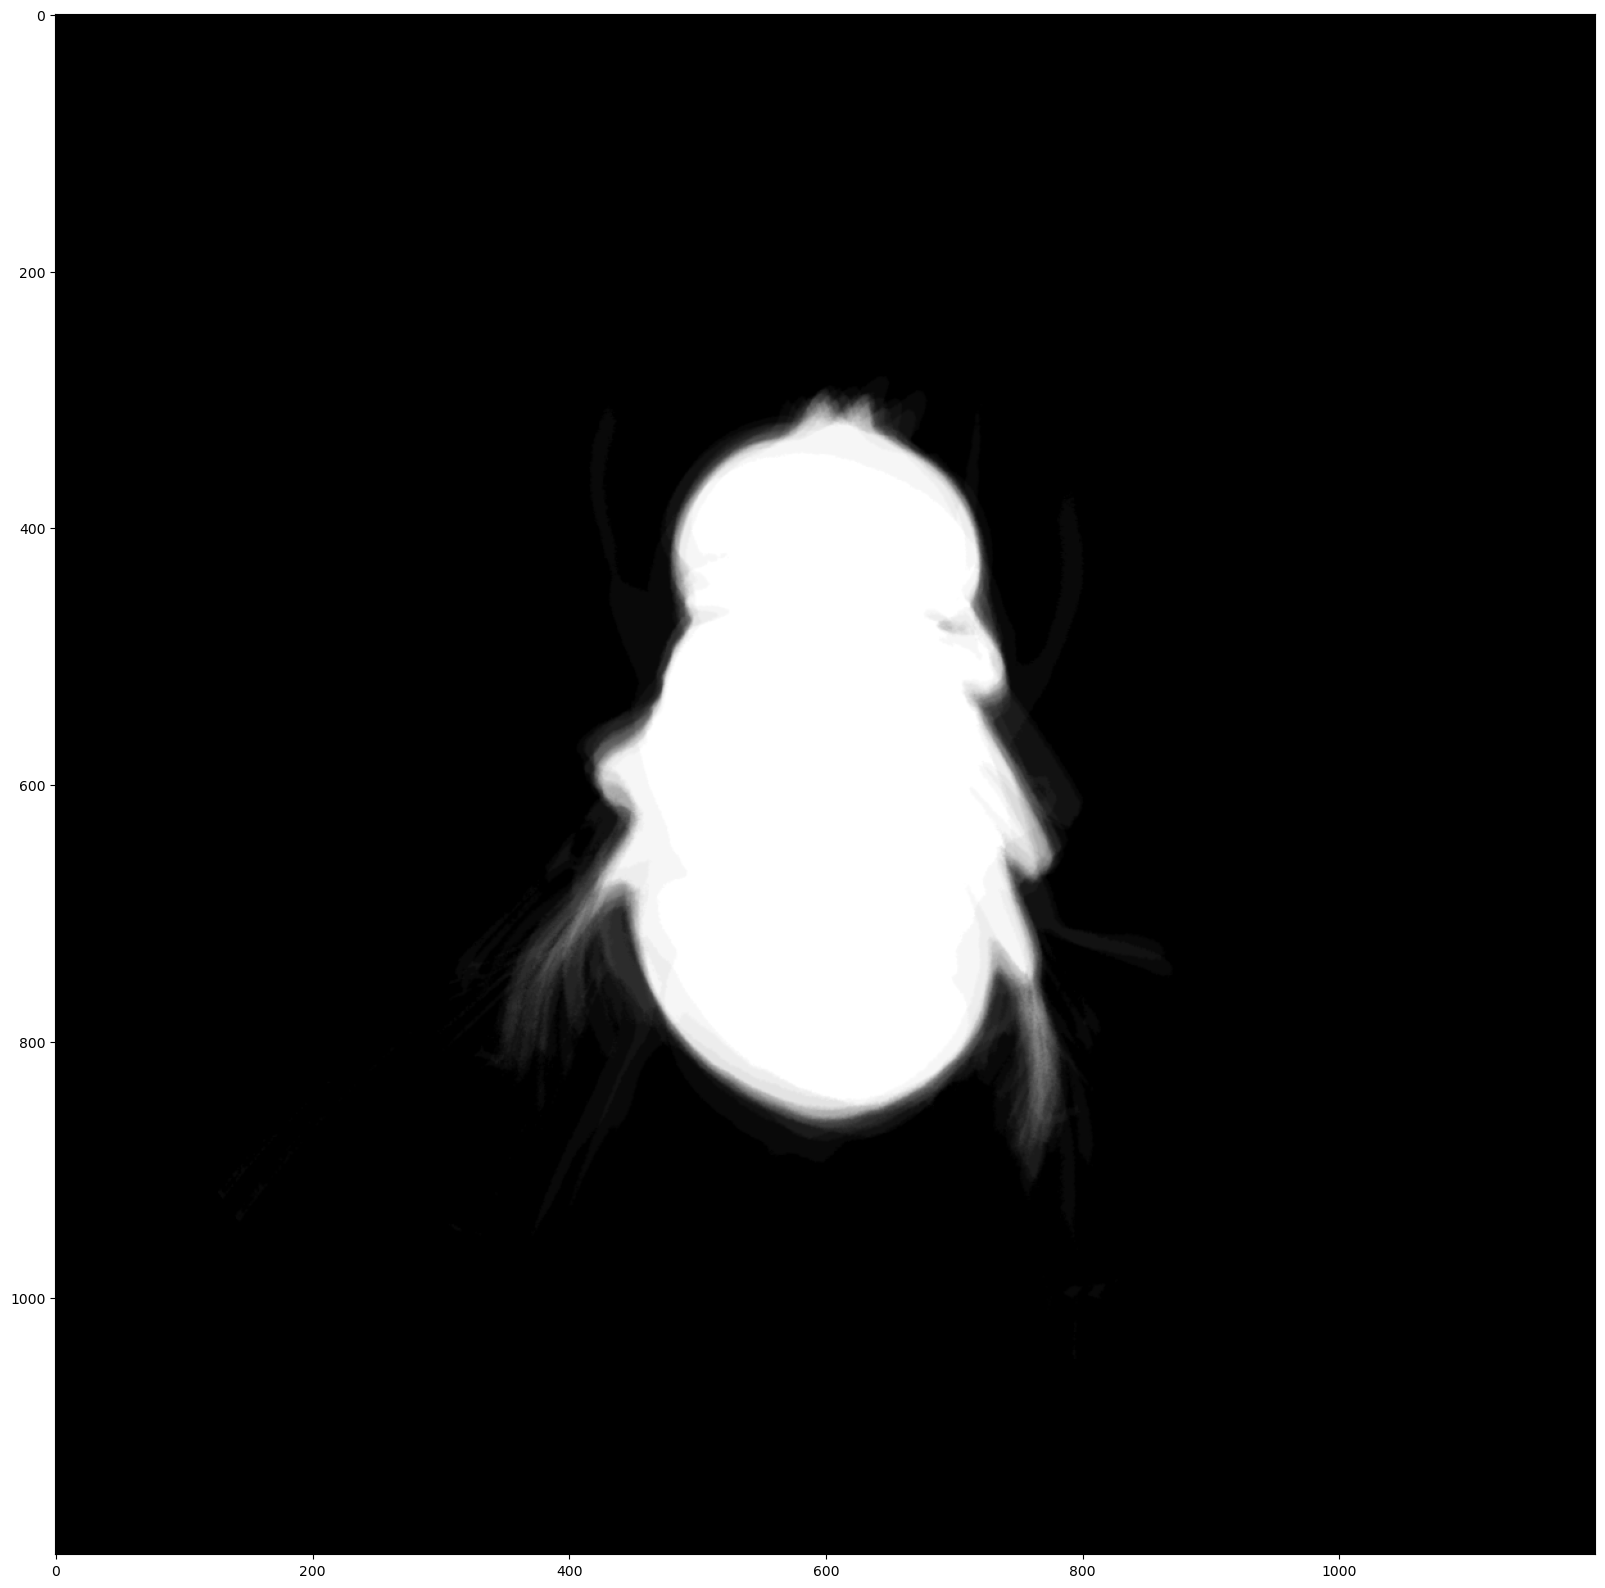

In [43]:
### Now with all the images we will create a mean tempate mask
final = []
for img in imgs.keys():
    final.append(imgs[img])
# print(final)
stacked = np.stack(final,axis=-1)
avg_mask = np.mean(stacked, axis = -1)
plt.figure(figsize=(20,20))
plt.imshow(avg_mask,cmap = 'gray')

## MSE Comparison
The entire image dataset will be tested against this average mask to determine the correct orientation of the fly. The MSE Rot and MSE No Rot will be logged as well as whether fly is No Rot or Rot.

In [82]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
def data_mse(data):
    data_results = {
        "file":[],
        "type":[],
        "MSE":[]
    }
    for file in data:
        name = file.split('/')[-1].strip('.png')
        mask_fly = contour_hrz_matrix(file)[1].astype(float)
        ## No Rotation or Rotation
        d = {
            "MSE No Rotation":mse(avg_mask,mask_fly),
            "MSE Rotation": mse(avg_mask,cv2.rotate(mask_fly,cv2.ROTATE_180))
        }
        # print(d)
        
        ## Save the min MSE Value
        data_results["file"].append(name)
        img_rot_type = list(d.keys())[list(d.values()).index(min(list(d.values())))]
        data_results['type'].append(img_rot_type)
        data_results["MSE"].append((d["MSE No Rotation"],d["MSE Rotation"])) # both MSE values...
        print("----------------")
    return data_results


In [45]:
imgs[list(imgs.keys())[0]].dtype
img1 = imgs[list(imgs.keys())[18]].astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 228.8775277724632
Rotation: 1184.6723333280186


In [48]:
np.random.choice(data)

'D:/20240502125110\\20240502125110_8832.png'

In [78]:
fly_mask_orig1, fly_mask_hrz1,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(np.random.choice(data))
img1 = fly_mask_hrz1.astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))


Angle Test!
Angle Value: 152.8981308385145
My Angle Value: 125.79626167702898
Angle Test!
Angle Value: 89.66997647577132
My Angle Value: 359.3399529515426


<< Original Angle: 152.8981308385145 >>
<< No Rotation Angle: 152.8981308385145 >>
<< Rotation Angle: -27.101869161485496 >>


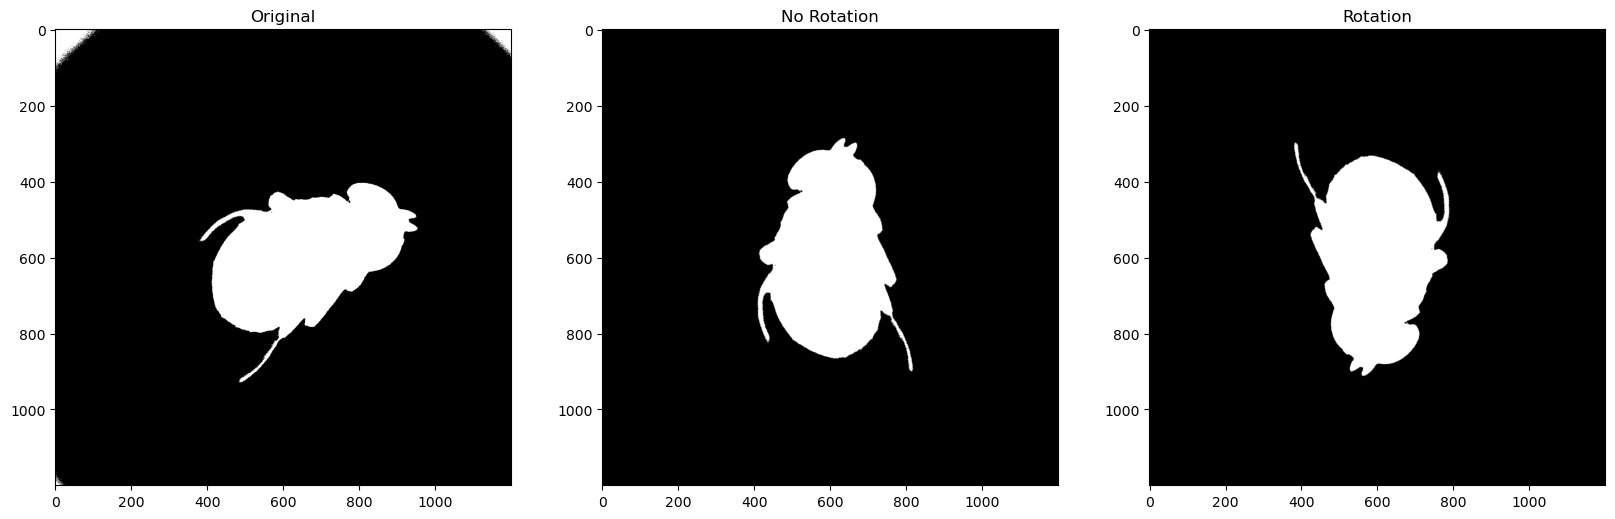

In [79]:
mask_fly_rot1 = cv2.rotate(copy.deepcopy(fly_mask_hrz1),cv2.ROTATE_180)

fig = plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(fly_mask_orig1,cmap='gray')
print(f"<< Original Angle: {np.rad2deg(angle_og)} >>")
plt.subplot(1,3,2)
plt.title("No Rotation")
# print("No Rotation Angle:",np.rad2deg(angle))
print(f"<< No Rotation Angle: {np.rad2deg(angle_og)} >>")
plt.imshow(fly_mask_hrz1,cmap='gray')
plt.subplot(1,3,3)
plt.title("Rotation")
print(f"<< Rotation Angle: {np.rad2deg(angle_og)-180} >>")
plt.imshow(mask_fly_rot1,cmap='gray')
plt.show()

In [80]:
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 348.72054905222507
Rotation: 1295.3426148756378


The `data_mse` function can take from 10-15 min based on size of the dataset.

In [83]:
results = data_mse(data)
results

Angle Test!
Angle Value: -151.56315612336587
My Angle Value: 236.87368775326829
Angle Test!
Angle Value: 89.95270842557198
My Angle Value: 359.90541685114397
----------------
Angle Test!
Angle Value: 171.74574168845953
My Angle Value: 163.49148337691906
Angle Test!
Angle Value: 89.86981333873817
My Angle Value: 359.73962667747634
----------------
Angle Test!
Angle Value: 145.2359769345717
My Angle Value: 110.47195386914338
Angle Test!
Angle Value: 89.75972890132275
My Angle Value: 359.5194578026455
----------------
Angle Test!
Angle Value: -175.96815834466332
My Angle Value: 188.06368331067338
Angle Test!
Angle Value: 89.8033080949423
My Angle Value: 359.60661618988456
----------------
Angle Test!
Angle Value: -156.8539241398017
My Angle Value: 226.29215172039665
Angle Test!
Angle Value: 89.87424645787968
My Angle Value: 359.74849291575936
----------------
Angle Test!
Angle Value: 61.19982473095833
My Angle Value: 302.3996494619167
Angle Test!
Angle Value: 89.8312433454884
My Angle Val

{'file': ['20240502125110\\20240502125110_0008',
  '20240502125110\\20240502125110_0011',
  '20240502125110\\20240502125110_0024',
  '20240502125110\\20240502125110_0026',
  '20240502125110\\20240502125110_0027',
  '20240502125110\\20240502125110_0029',
  '20240502125110\\20240502125110_0031',
  '20240502125110\\20240502125110_0041',
  '20240502125110\\20240502125110_0046',
  '20240502125110\\20240502125110_0052',
  '20240502125110\\20240502125110_0062',
  '20240502125110\\20240502125110_0104',
  '20240502125110\\20240502125110_0105',
  '20240502125110\\20240502125110_0138',
  '20240502125110\\20240502125110_0192',
  '20240502125110\\20240502125110_0203',
  '20240502125110\\20240502125110_0209',
  '20240502125110\\20240502125110_0212',
  '20240502125110\\20240502125110_0215',
  '20240502125110\\20240502125110_0230',
  '20240502125110\\20240502125110_0235',
  '20240502125110\\20240502125110_0240',
  '20240502125110\\20240502125110_0258',
  '20240502125110\\20240502125110_0259',
  '20240

The dictionary is then transformed into a dataframe for additional processing and subsequent plotting

In [84]:
results_df = pd.DataFrame(results)
results_df.head()

file             type  \
0  20240502125110\20240502125110_0008  MSE No Rotation   
1  20240502125110\20240502125110_0011     MSE Rotation   
2  20240502125110\20240502125110_0024     MSE Rotation   
3  20240502125110\20240502125110_0026     MSE Rotation   
4  20240502125110\20240502125110_0027     MSE Rotation   

                                        MSE  
0  (396.37027653238374, 1007.3766886851608)  
1  (1134.8088490026214, 362.66883923079644)  
2  (1264.0470191415106, 400.93834305024075)  
3   (1277.8443045581776, 394.6114088736535)  
4   (1304.3256458280187, 409.9326055502408)

# Plot all data

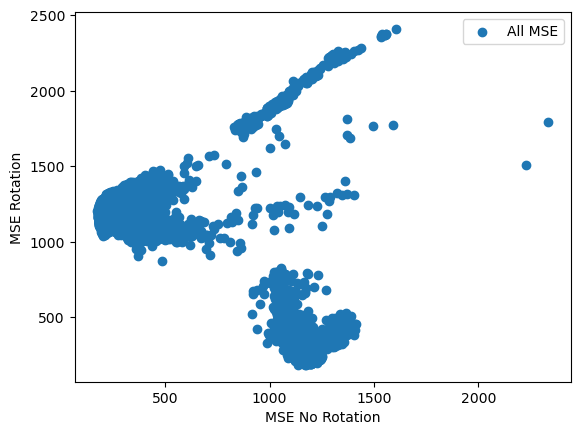

In [87]:
plt.scatter(results_df['MSE'].apply(lambda x: x[0]),results_df['MSE'].apply(lambda x: x[1]),label = 'All MSE')
plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

## Plot of MSE ERROR No Rotation vs Rotation for Large Dataset

Using the average mask from before we will now look at all the images in the dataset to determine accuracy. 

In [88]:
results_df

file             type  \
0     20240502125110\20240502125110_0008  MSE No Rotation   
1     20240502125110\20240502125110_0011     MSE Rotation   
2     20240502125110\20240502125110_0024     MSE Rotation   
3     20240502125110\20240502125110_0026     MSE Rotation   
4     20240502125110\20240502125110_0027     MSE Rotation   
...                                  ...              ...   
8857  20240502125110\20240502125110_8799  MSE No Rotation   
8858  20240502125110\20240502125110_8817     MSE Rotation   
8859  20240502125110\20240502125110_8842     MSE Rotation   
8860  20240502125110\20240502125110_8851     MSE Rotation   
8861  20240502125110\20240502125110_8861  MSE No Rotation   

                                           MSE  
0     (396.37027653238374, 1007.3766886851608)  
1     (1134.8088490026214, 362.66883923079644)  
2     (1264.0470191415106, 400.93834305024075)  
3      (1277.8443045581776, 394.6114088736535)  
4      (1304.3256458280187, 409.9326055502408)  
...                                        ...  
8857  (326.11751428039975, 1169.2134086256374)  
8858  (1218.8059533677017, 239.98722821889186)  
8859  (1225.3036141811938, 247.94541269309818)  
8860   (1218.824612147463, 244.87449682008227)  
8861  (303.46789567920905, 1183.6592810958762)  

[8862 rows x 3 columns]

In [89]:
# Plot Type MSE NO ROTATION with VALUE MSE (X AXIS)
mse_norot = results_df[results_df['type']=='MSE No Rotation']
print(mse_norot)
mse_rot = results_df[results_df['type']=='MSE Rotation']
print(mse_rot)


                                    file             type  \
0     20240502125110\20240502125110_0008  MSE No Rotation   
5     20240502125110\20240502125110_0029  MSE No Rotation   
6     20240502125110\20240502125110_0031  MSE No Rotation   
8     20240502125110\20240502125110_0046  MSE No Rotation   
10    20240502125110\20240502125110_0062  MSE No Rotation   
...                                  ...              ...   
8842  20240502125110\20240502125110_8649  MSE No Rotation   
8845  20240502125110\20240502125110_8679  MSE No Rotation   
8849  20240502125110\20240502125110_8730  MSE No Rotation   
8857  20240502125110\20240502125110_8799  MSE No Rotation   
8861  20240502125110\20240502125110_8861  MSE No Rotation   

                                           MSE  
0     (396.37027653238374, 1007.3766886851608)  
5      (395.1441446871455, 1315.0210267803996)  
6       (390.811532038336, 1330.7110100145264)  
8       (366.9861022764314, 1281.100814925241)  
10    (335.85252861571

In [90]:
len(results_df)


8862

In [92]:
len(mse_norot)


6509

0       5400.000387
1       6981.284394
2       6723.951834
3       7027.140760
4       7201.448330
           ...     
8854    6397.122814
8855    6883.384758
8858    6830.338330
8859    6337.198682
8860    7106.547459
Name: MSE, Length: 5382, dtype: float64

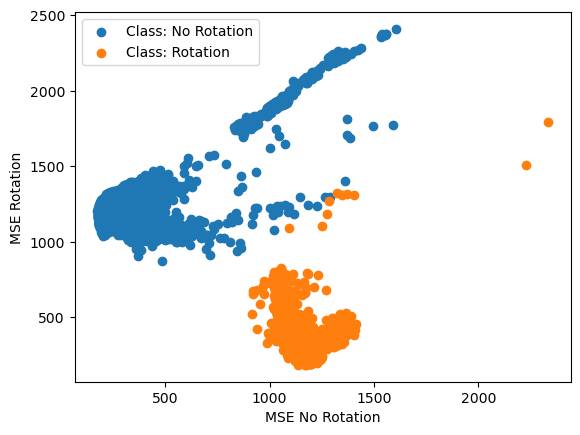

In [94]:
plt.scatter(mse_norot['MSE'].apply(lambda x: x[0]),mse_norot['MSE'].apply(lambda x: x[1]),label = 'Class: No Rotation')
plt.scatter(mse_rot['MSE'].apply(lambda x: x[0]),mse_rot['MSE'].apply(lambda x: x[1]),label = 'Class: Rotation')
# Plot TYPE MSE ROTATIO with VALUE MSE (Y axis)

plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()

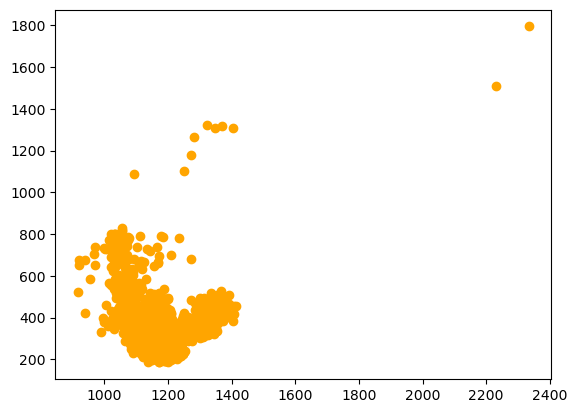

In [98]:
plt.scatter(np.array(mse_rot['MSE'].apply(lambda x: x[0])),np.array(mse_rot['MSE'].apply(lambda x: x[1])),color = 'orange',label = 'Class: Rotation')

# Original Plot

In [ ]:
# data source
fem_dat_static ='data/20231228154547.txt'
# female fly heading and led position data
df_fem_static = pd.read_csv(fem_dat_static, names = ['time','fly heading','led position'],sep = " ")

# compute change over time
df_fem_static['delta-t'] = df_fem_static['time'] - df_fem_static['time'][0] 


# Reestablish a new Textfile 

# New vs Original Plot

# EXTRAS

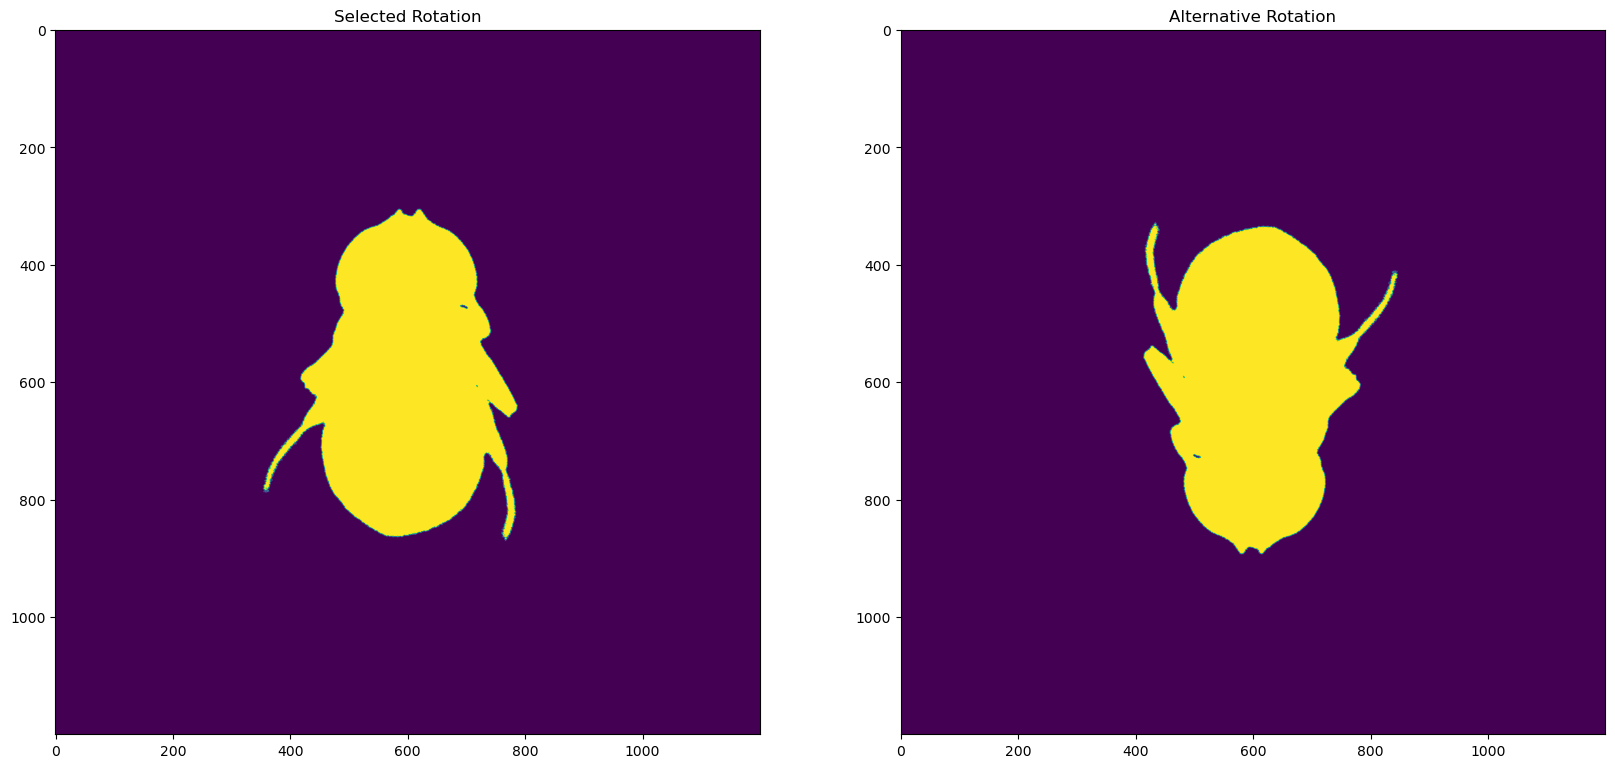

In [42]:
## Test Image (18th image in the stack)
img1 = imgs[list(imgs.keys())[18]].astype('float64')
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title("Selected Rotation")
plt.imshow(img1) 
plt.subplot(122)
plt.title("Alternative Rotation")
plt.imshow(cv2.rotate(img1,cv2.ROTATE_180))

In [43]:
## Comparison between two images
def mse(img1, img2):
    area_px = img1.shape[0]*img1.shape[1]
    px_diff = cv2.subtract(img1, img2)
    sum_err = np.sum(px_diff**2)
    mse = sum_err/(float(area_px))
    return mse
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 255.10822447569433
Rotation: 1138.383849197916


In [20]:
fly_mask_hrz = fly_mask_hrz.astype('float64')
error = mse(avg_mask,fly_mask_hrz)
error2 = mse(avg_mask,cv2.rotate(fly_mask_hrz,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

No rotation: 1946.0575228090283
Rotation: 1709.1743328090274
